In [1]:
import numpy as np
from numpy import linalg as LA
import math as m
import os
from matplotlib.image import imread
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing default values
import scipy.io as sio
from scipy.optimize import minimize
import timeit
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint
from torch.autograd import grad

# set all fontsizes to 12
rcParams["font.size"] = 12
rcParams["axes.axisbelow"] = True # make sure grid is behind plots

## Example: solve differential equation for bar

Distributed loading

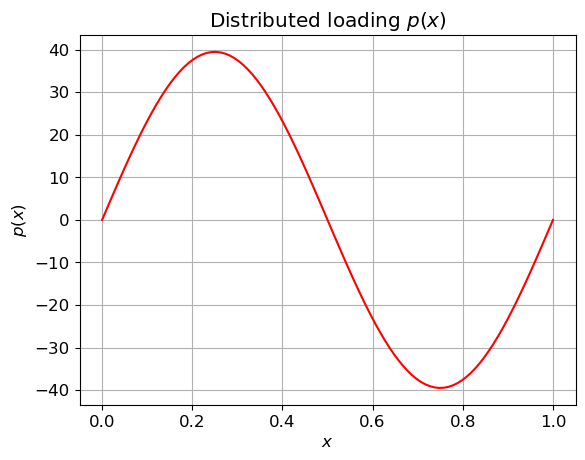

In [2]:
#%%  Analytical solution
#analytical solution
u_analytic = lambda x: np.sin(2 * np.pi * x / L)

# Problem data
#define anonymous (lambda) functions
E = lambda x: 1
A = lambda x: 1
L = 1
u0 = [0,0]  # Dirichlet boundary conditions for both edges
#define anonymous (lambda) function
distLoad = lambda x: 4 * np.pi**2 * E(x) * A(x) / L**2 * torch.sin(2 * np.pi * x / L)
# alternative: 
#def distLoad(x):
#    return 4 * np.pi**2 * E(x) * A(x) / L**2 * torch.sin(2 * np.pi * x / L)


x = torch.linspace(0, L, 100, requires_grad=True).view((-1, 1))


fig, ax = plt.subplots(nrows=1, ncols=1) # Create a figure with one subplot
ax.plot(x.detach().numpy(), distLoad(x).detach().numpy(),color='red', label='Distributed loading')
plt.xlabel(r'$x$')
plt.ylabel('$p(x)$')
ax.set_title(r'Distributed loading $p(x)$')
ax.grid(visible=True)
plt.show()

Define get_derivative

In [3]:
#%% define a function to get_derivative, from Kollmannsberger et al.
dtype = torch.float
device = torch.device("cpu")
def get_derivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)


Define NN

In [4]:
#%% Generate NN model
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # Define layers for the neural network
        self.fc1 = nn.Linear(1, 10)  # Fully connected layer with 1 input and 10 output units
        self.fc2 = nn.Linear(10, 1)  # Fully connected layer with 10 input and 1 output units
        self.tanh = nn.Tanh()         # Tanh activation function

    def forward(self, x):
        # Define the forward pass of the neural network
        x = self.tanh(self.fc1(x))  # Apply sigmoid activation to the first layer
        x = self.fc2(x)  # Output layer (no activation function)
        return x
    
# Create an instance of the SinNet model
model = MyNet()


Define loss function

In [5]:
#%% Define loss function
def criterion(x, u_pred):
        """Compute the cost function."""
        # Differential equation loss
        du_dx=get_derivative(u_pred, x, 1)
        differential_equation_loss = get_derivative( E(x) * A(x) * du_dx,x,1)   + distLoad(x)
        differential_equation_loss = torch.sum(differential_equation_loss ** 2)
        # Boundary condition loss initialization
        boundary_condition_loss = 0
        # Sum over dirichlet boundary condition losses
        boundary_condition_loss += (u_pred[0] - u0[0]) ** 2
        boundary_condition_loss += (u_pred[-1] -u0[1]) ** 2
        
        return differential_equation_loss, boundary_condition_loss

Define closure

In [6]:
#%% function for closure

# Create a function for closure
def closure(x_tensor):
    optimizer.zero_grad() # Clear gradients from the previous iteration
    outputs = model(x_tensor)  #get displacements frp
    loss_de,loss_bc = criterion(x_tensor, outputs) # Compute the loss
    loss = loss_de+100.*loss_bc
# Calculate the L1 regularization term
    l1_regularization = torch.tensor(0.)
    for param in model.parameters():
        l1_regularization += torch.norm(param, p=1)

    # Add the L1 regularization term to the loss
    lambda_l1=0.
    loss += lambda_l1 * l1_regularization # Compute the loss
    loss.backward() # Compute gradients using backpropagation
    return loss,loss_de,loss_bc


Training

In [7]:
#%% training
prev_loss = float('inf')  # Initialize with a large value
tolerance = 1.e-7
max_no_epoch=8000


optim_alg='Adam'
if optim_alg=='LBFGS':
    optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=max_no_epoch,tolerance_change=tolerance)
#alternatively:
elif optim_alg=='Adam': 
    optimizer = optim.Adam(model.parameters(), lr=0.01)
elif optim=='SGD': 
    optimizer=torch.optim.SGD(model.parameters(), lr=0.1)

#training points for the d.e.
x = torch.linspace(0, L, 20, requires_grad=True).view((-1, 1))

#for saving training result
differential_equation_loss_history = np.zeros(max_no_epoch)
boundary_condition_loss_history = np.zeros(max_no_epoch)
# Training loop
for epoch in range(max_no_epoch):
    def closure_wrapper():
        loss,loss_de,loss_bc = closure(x)
        differential_equation_loss_history[epoch] += loss_de.item()
        boundary_condition_loss_history[epoch] += loss_bc.item()
        return loss 
    loss=optimizer.step(closure_wrapper)
    

# Print the loss every epoch
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}], Loss: {loss.item():.4f}")
            
    loss_change = prev_loss - loss.item()
    prev_loss = loss.item()

    # Check if the optimizer has converged (you can modify this condition)

    if optim_alg=='LBFGS':
        if loss_change < tolerance:
            print(f"Optimizer has converged. Stopping training.")
            break



Epoch [1], Loss: 14832.4424
Epoch [2], Loss: 14808.8018
Epoch [3], Loss: 14787.1992
Epoch [4], Loss: 14767.2959
Epoch [5], Loss: 14748.7529
Epoch [6], Loss: 14731.2900
Epoch [7], Loss: 14714.5996
Epoch [8], Loss: 14698.3760
Epoch [9], Loss: 14682.3682
Epoch [10], Loss: 14666.3721
Epoch [11], Loss: 14650.2178
Epoch [12], Loss: 14633.7461
Epoch [13], Loss: 14616.8213
Epoch [14], Loss: 14599.3057
Epoch [15], Loss: 14581.0781
Epoch [16], Loss: 14562.0283
Epoch [17], Loss: 14542.0596
Epoch [18], Loss: 14521.0967
Epoch [19], Loss: 14499.0752
Epoch [20], Loss: 14475.9502
Epoch [21], Loss: 14451.6885
Epoch [22], Loss: 14426.2598
Epoch [23], Loss: 14399.6260
Epoch [24], Loss: 14371.7461
Epoch [25], Loss: 14342.5566
Epoch [26], Loss: 14311.9639
Epoch [27], Loss: 14279.8525
Epoch [28], Loss: 14246.0791
Epoch [29], Loss: 14210.4961
Epoch [30], Loss: 14172.9434
Epoch [31], Loss: 14133.2764
Epoch [32], Loss: 14091.3662
Epoch [33], Loss: 14047.0977
Epoch [34], Loss: 14000.3740
Epoch [35], Loss: 13951

Plot loss_function

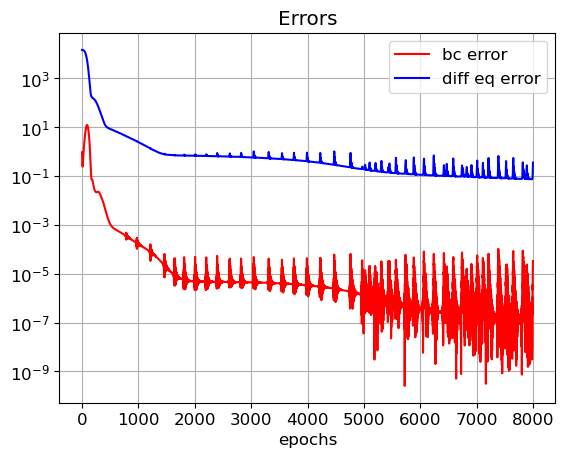

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1) # Create a figure with one subplot
ax.semilogy(np.arange(len(boundary_condition_loss_history)), boundary_condition_loss_history,color='red', label='bc error')
ax.semilogy(np.arange(len(boundary_condition_loss_history)), differential_equation_loss_history,color='blue',label="diff eq error")
plt.xlabel(r'epochs')
ax.set_title(r'Errors')
ax.grid(visible=True)
ax.legend(loc='best') 
plt.show()

Plot predicted $u(x)$ compared against analytical solution

<function matplotlib.pyplot.show(close=None, block=None)>

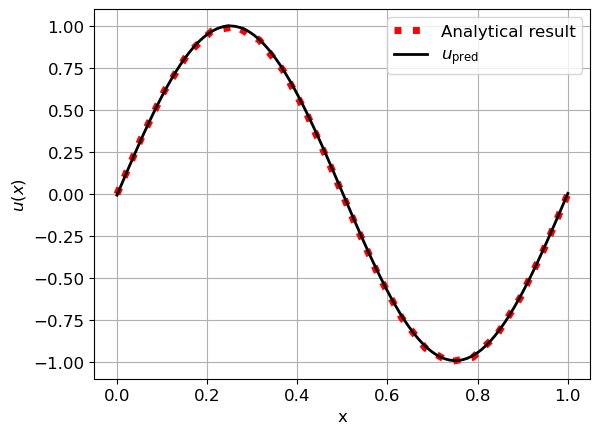

In [9]:
#%%
#analytical solution
u_analytic = lambda x: torch.sin(2 * np.pi * x / L)
fig, ax = plt.subplots(nrows=1, ncols=1) # Create a figure with one subplot
ax.plot(x.detach().numpy(), u_analytic(x).detach().numpy(),color='r',linestyle=':',linewidth=5, label='Analytical result')
x = torch.linspace(0, L, 100, requires_grad=True).view((-1, 1))
pred_displacements = model(x)  #get displacements
ax.plot(x.detach().numpy(), pred_displacements.detach().numpy(),color='k',linestyle='-',linewidth=2, label="$u_{\mathrm{pred}}$")
ax.legend(loc='best') 
plt.xlabel('x')
plt.ylabel('$u(x)$')   
ax.grid(visible=True)
plt.show

## Inverse problem

Problem data

In [10]:

#%% Problem data
N = 20
L = 1

def generate_grid_1d(length, samples=20, initial_coordinate=0.0):
    """Generate an evenly space grid of a given length and a given number of samples."""

    # Generate the grid
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)

    # Reshape on a column tensor and return
    return x.view(samples, 1)


x = generate_grid_1d(L, N)
u_analytic = lambda x: torch.sin(2*np.pi*x)

distLoad = lambda x: -2*(3*x**2 - 2*x)*np.pi*torch.cos(2*np.pi*x) + 4*(x**3 - x**2 + 1)*np.pi**2*torch.sin(2*np.pi*x)



Define NN

In [11]:
class pinnModel(nn.Module):
    def __init__(self):
        super(pinnModel, self).__init__()
        # Define layers for the neural network
        self.fc1 = nn.Linear(1, 10)  # Fully connected layer with 1 input and 10 output units
        self.fc2 = nn.Linear(10, 1)  # Fully connected layer with 10 input and 1 output units
        self.tanh = nn.Tanh()         # Tanh activation function

    def forward(self, x):
        # Define the forward pass of the neural network
        x = self.tanh(self.fc1(x))  # Apply sigmoid activation to the first layer
        x = self.fc2(x)  # Output layer (no activation function)
        return x
    
# Create an instance of the SinNet model
model = pinnModel()

Define loss function

In [ ]:
#%% Define loss function
def criterion(model,x):
        """Compute the cost function."""
        u=u_analytic(x)
        strain=get_derivative(u, x, 1)
        EA=model(x)
        N = EA * strain      # normal force
        # Differential equation loss
        differential_equation_loss = get_derivative(N, x, 1)  + distLoad(x)
        differential_equation_loss = torch.sum(differential_equation_loss ** 2)  
        
        return differential_equation_loss




Define closure

In [13]:
#%% function for closure
# Create a function for closure
def closure(x_tensor):
    optimizer.zero_grad() # Clear gradients from the previous iteration
    loss_de = criterion(model,x_tensor) # Compute the loss
    loss = loss_de
# Calculate the L1 regularization term
    l1_regularization = torch.tensor(0.)
    for param in model.parameters():
        l1_regularization += torch.norm(param, p=1)

    # Add the L1 regularization term to the loss
    lambda_l1=0.
    loss += lambda_l1 * l1_regularization # Compute the loss
    loss.backward() # Compute gradients using backpropagation
    return loss,loss_de


Training

In [14]:
#%% training
prev_loss = float('inf')  # Initialize with a large value
tolerance = 1.e-7
max_no_epoch=8000


optim_alg='LBFGS'
if optim_alg=='LBFGS':
    optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=max_no_epoch,tolerance_change=tolerance)
#alternatively:
elif optim_alg=='Adam': 
    optimizer = optim.Adam(model.parameters(), lr=0.01)
elif optim=='SGD': 
    optimizer=torch.optim.SGD(model.parameters(), lr=0.1)


#for saving training result
differential_equation_loss_history = np.zeros(max_no_epoch)
# Training loop
for epoch in range(max_no_epoch):
    def closure_wrapper():
        loss,loss_de = closure(x)
        differential_equation_loss_history[epoch] += loss_de.item()
        return loss 
    loss=optimizer.step(closure_wrapper)

# Print the loss every epoch
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}], Loss: {loss.item():.4f}")
            
    loss_change = prev_loss - loss.item()
    prev_loss = loss.item()

    # Check if the optimizer has converged (you can modify this condition)

    if optim_alg=='LBFGS':
        if loss_change < tolerance:
            print(f"Optimizer has converged. Stopping training.")
            break

Epoch [1], Loss: 25302.0840
Epoch [2], Loss: 0.0011
Epoch [3], Loss: 0.0011
Epoch [4], Loss: 0.0011
Epoch [5], Loss: 0.0011
Epoch [6], Loss: 0.0011
Epoch [7], Loss: 0.0011
Epoch [8], Loss: 0.0011
Epoch [9], Loss: 0.0011
Epoch [10], Loss: 0.0011
Epoch [11], Loss: 0.0011
Epoch [12], Loss: 0.0011
Epoch [13], Loss: 0.0011
Epoch [14], Loss: 0.0011
Epoch [15], Loss: 0.0011
Epoch [16], Loss: 0.0011
Epoch [17], Loss: 0.0011
Optimizer has converged. Stopping training.


Plot result

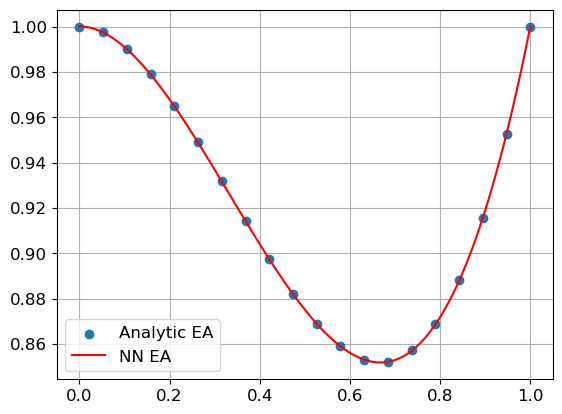

In [15]:
#%% plot result
EA_analytic = lambda x: x**3 - x**2 + 1
#
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(x.detach().numpy(), EA_analytic(x).detach().numpy(), label='Analytic EA')
#
#x_dense_tensor=torch.tensor(xdense, requires_grad=True).float().unsqueeze(1)
xdense = generate_grid_1d(L, 100)
pred_EA=model(xdense)

plt.plot(xdense.detach().numpy(),pred_EA.detach().numpy(), 'r', label='NN EA')
ax.legend(loc='best')
ax.grid(visible=True)
plt.show()

## Combining data and d.e.


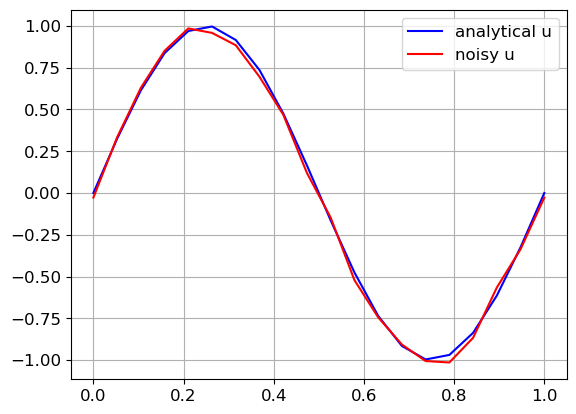

In [16]:

u_random=u_analytic(x) + 0.1 * (torch.rand(len(x), 1) - 0.5).type(torch.FloatTensor)
#print(u_random)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x.detach().numpy(),u_analytic(x).detach().numpy(),color='blue',label='analytical u')
plt.plot(x.detach().numpy(),u_random.detach().numpy(),color='red',label='noisy u')
ax.grid(visible=True)
ax.legend(loc='best') 
plt.show()


In [17]:
class pinnModel(nn.Module):
    def __init__(self):
        super(pinnModel, self).__init__()
        # Define layers for the neural network
        self.fc1 = nn.Linear(1, 20)  # Fully connected layer with 1 input and 10 output units
        self.fc2 = nn.Linear(20, 2)  # Fully connected layer with 10 input and 2 output units
        self.tanh = nn.Tanh()         # Tanh activation function

    def forward(self, x):
        # Define the forward pass of the neural network
        x = self.tanh(self.fc1(x))  # Apply sigmoid activation to the first layer
        x = self.fc2(x)  # Output layer (no activation function)
        return x
    
# Create an instance of the pinnModel model
model = pinnModel()

In [18]:
def closure(x):
    optimizer.zero_grad() # Clear gradients from the previous iteration
    output_tensor =model(x)
    u, EA=torch.split(output_tensor,1,dim=1)
    strain=get_derivative(u, x, 1)
    N=EA*strain
    # Differential equation loss
    loss_de = get_derivative(N, x, 1) + distLoad(x)
    loss_de = torch.sum(loss_de ** 2).view(1)
    #measurement points loss
    MSEcriterion = nn.MSELoss()
    mse_loss = MSEcriterion(u, u_random)
    
# Calculate the L1 regularization term
    l1_regularization = torch.tensor(0.)
    for param in model.parameters():
        l1_regularization += torch.norm(param, p=1)

    # Add the L1 regularization term to the loss
    lambda_l1=0.
    loss = loss_de+100.*mse_loss+ lambda_l1 * l1_regularization # Compute the loss
    loss.backward(retain_graph=True) # Compute gradients using backpropagation
    # Manually release the computation graph
    #del loss, loss_de, mse_loss, l1_regularization
    return loss,loss_de

In [23]:
#%% training
prev_loss = float('inf')  # Initialize with a large value
tolerance = 1.e-7
max_no_epoch=60000


optim_alg='Adam'
if optim_alg=='LBFGS':
    optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=max_no_epoch,tolerance_change=tolerance)
#alternatively:
elif optim_alg=='Adam': 
    optimizer = optim.Adam(model.parameters(), lr=0.001)
elif optim=='SGD': 
    optimizer=torch.optim.SGD(model.parameters(), lr=0.1)


#for saving training result
differential_equation_loss_history = np.zeros(max_no_epoch)
# Training loop
for epoch in range(max_no_epoch):
    def closure_wrapper():
        loss,loss_de = closure(x)
        differential_equation_loss_history[epoch] = loss_de.item()
        return loss 
    loss=optimizer.step(closure_wrapper)

# Print the loss every epoch
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}], Loss: {loss.item():.4f}")
            
    loss_change = prev_loss - loss.item()
    prev_loss = loss.item()

    # Check if the optimizer has converged (you can modify this condition)

    if optim_alg=='LBFGS':
        if loss_change < tolerance:
            print(f"Optimizer has converged. Stopping training.")
            break




Epoch [1], Loss: 0.0695
Epoch [2], Loss: 5.7454
Epoch [3], Loss: 0.4393
Epoch [4], Loss: 1.2589
Epoch [5], Loss: 3.3256
Epoch [6], Loss: 2.5954
Epoch [7], Loss: 0.8416
Epoch [8], Loss: 0.0701
Epoch [9], Loss: 0.6965
Epoch [10], Loss: 1.5751
Epoch [11], Loss: 1.6068
Epoch [12], Loss: 0.8947
Epoch [13], Loss: 0.2091
Epoch [14], Loss: 0.1134
Epoch [15], Loss: 0.5253
Epoch [16], Loss: 0.9025
Epoch [17], Loss: 0.8523
Epoch [18], Loss: 0.4681
Epoch [19], Loss: 0.1278
Epoch [20], Loss: 0.1028
Epoch [21], Loss: 0.3325
Epoch [22], Loss: 0.5278
Epoch [23], Loss: 0.4855
Epoch [24], Loss: 0.2672
Epoch [25], Loss: 0.0911
Epoch [26], Loss: 0.0997
Epoch [27], Loss: 0.2365
Epoch [28], Loss: 0.3305
Epoch [29], Loss: 0.2832
Epoch [30], Loss: 0.1534
Epoch [31], Loss: 0.0731
Epoch [32], Loss: 0.1043
Epoch [33], Loss: 0.1868
Epoch [34], Loss: 0.2178
Epoch [35], Loss: 0.1658
Epoch [36], Loss: 0.0924
Epoch [37], Loss: 0.0722
Epoch [38], Loss: 0.1116
Epoch [39], Loss: 0.1523
Epoch [40], Loss: 0.1446
Epoch [41

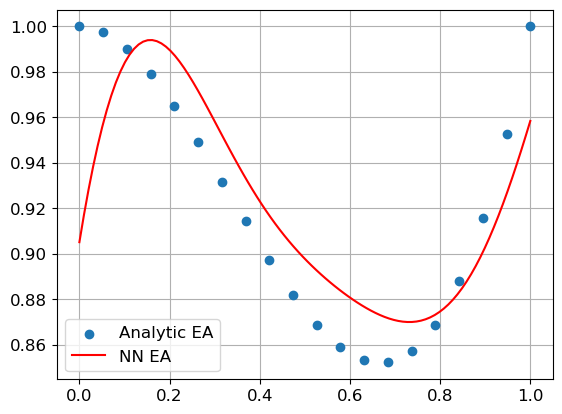

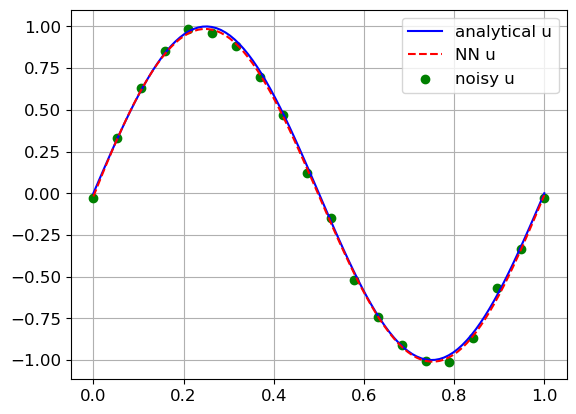

In [22]:
output_tensor =model(x)
u, EA=torch.split(output_tensor,1,dim=1)

#%% plot result
EA_analytic = lambda x: x**3 - x**2 + 1
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(x.detach().numpy(), EA_analytic(x).detach().numpy(), label='Analytic EA')
#
xdense = generate_grid_1d(L, 100)
output_tensor =model(xdense)
u, EA=torch.split(output_tensor,1,dim=1)

plt.plot(xdense.detach().numpy(),EA.detach().numpy(), 'r', label='NN EA')
ax.grid(visible=True)
ax.legend(loc='best')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(xdense.detach().numpy(),u_analytic(xdense).detach().numpy(),color='blue',label='analytical u')
plt.plot(xdense.detach().numpy(),u.detach().numpy(),color='red',linestyle='--',label='NN u')
plt.scatter(x.detach().numpy(),u_random.detach().numpy(),color='green',label='noisy u')
ax.grid(visible=True)
ax.legend(loc='best') 
plt.show()


